In [1]:
from pytorch_lightning.utilities.model_summary import summarize
from datasets import load_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset
from estimator import TransformerEstimator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import CSVLogger

/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
#Tuning GluonTS models with Optuna
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import json
import optuna
import torch
from gluonts.mx import Trainer
from gluonts.evaluation import Evaluator
import time
import random

In [3]:
import torch
print(torch.cuda.is_available())
#print(torch.__version__)
print(torch.cuda.device_count())

True
1


In [4]:
import seaborn as sns

In [5]:
logger = CSVLogger("logs", name="vanilla")

In [6]:
class TransformerTuningObjective:  
    def __init__(self, dataset, prediction_length, freq,embed_dim, metric_type="mean_wQuantileLoss"):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type
        self.dim = embed_dim
    
    def get_params(self, trial) -> dict:
        return {
        "context_length": trial.suggest_int("context_length", dataset.metadata.prediction_length, dataset.metadata.prediction_length*7,4),
        "max_epochs": trial.suggest_int("max_epochs", 1, 10,2),
        "batch_size": trial.suggest_int("batch_size", 128, 256, 64),
        "num_encoder_layers": trial.suggest_int("num_encoder_layers", 2, 16,4),
        "num_decoder_layers": trial.suggest_int("num_decoder_layers", 2, 16,4),
        }
     
    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = TransformerEstimator(
        freq=self.freq,
        prediction_length=self.prediction_length,
        context_length=params['context_length'],

        nhead=2,
        num_encoder_layers=params['num_encoder_layers'],
        num_decoder_layers=params['num_decoder_layers'],
        dim_feedforward=16,
        activation="gelu",

        num_feat_static_cat=1,
        cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)],
        embedding_dimension=[self.dim],

        batch_size=params['batch_size'],
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=params['max_epochs'], accelerator='auto', gpus=1, logger=logger)
    )#
        predictor = estimator.train(
        training_data=self.dataset.train,
        # validation_data=val_ds,
        num_workers=8,
        # shuffle_buffer_length=1024
        )
        
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=self.dataset.test, 
            predictor=predictor
        )
        forecasts = list(forecast_it)
        # if layer == layers[0]:
        tss = list(ts_it)
        
        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
        return agg_metrics[self.metric_type]

In [7]:
embedding_dim = [3, 3, 3, 4, 3, 4, 4, 3]
data = ["electricity","traffic", "m4_hourly", "m4_daily", "m4_weekly", "m4_monthly", "m4_quarterly", "solar-energy"]


### Scaling experiment

In [ ]:

# seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
seed_list = [0, 42, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000]
value=[]
seed_l = []
dataset_name = []
crps = []
dataset = get_dataset("electricity")
params = []
dim = 3
prediction_length = 24
freq = dataset.metadata.freq
for layer in [2, 4, 8, 12, 16, 20, 24, 28]:
    value = []
    for seed in seed_list:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        estimator = TransformerEstimator(
            freq=dataset.metadata.freq,
            prediction_length=24,
            context_length=144,
            nhead=2,
            num_encoder_layers=layer,
            num_decoder_layers=6,
            dim_feedforward=16,
            activation="gelu",

            num_feat_static_cat=1,
            cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)],
            embedding_dimension=[dim],

            batch_size=192,
            num_batches_per_epoch=100,
            trainer_kwargs=dict(max_epochs=9, accelerator='auto', gpus=1, logger=logger))#
        predictor = estimator.train(
        training_data=dataset.train,
         # validation_data=val_ds,
         num_workers=8,
         # shuffle_buffer_length=1024
        )


        forecast_it, ts_it = make_evaluation_predictions(dataset=dataset.test, predictor=predictor)
        forecasts = list(forecast_it)
         # if layer == layers[0]:
        tss = list(ts_it)

        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss), iter(forecasts))
        # agg_metrics["trainable_parameters"] = summarize(estimator.create_lightning_module()).trainable_parameters
        value.append(agg_metrics['mean_wQuantileLoss'])
        seed_l.append(seed)
        # dataset_name.append(i)
        print(seed)
    print(layer)
    crps.append(np.mean(value))
    params.append(summarize(estimator.create_lightning_module()).trainable_parameters)

/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/traine

Epoch 0: : 100it [00:29,  3.40it/s, loss=6.14, v_num=4, train_loss=6.540]

Epoch 0, global step 100: 'train_loss' reached 6.54178 (best 6.54178), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:28,  3.48it/s, loss=5.76, v_num=4, train_loss=5.900]

Epoch 1, global step 200: 'train_loss' reached 5.89854 (best 5.89854), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:29,  3.40it/s, loss=5.62, v_num=4, train_loss=5.680]

Epoch 2, global step 300: 'train_loss' reached 5.68404 (best 5.68404), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:28,  3.45it/s, loss=5.52, v_num=4, train_loss=5.600]

Epoch 3, global step 400: 'train_loss' reached 5.59905 (best 5.59905), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:28,  3.52it/s, loss=5.57, v_num=4, train_loss=5.520]

Epoch 4, global step 500: 'train_loss' reached 5.51908 (best 5.51908), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:28,  3.46it/s, loss=5.47, v_num=4, train_loss=5.470]

Epoch 5, global step 600: 'train_loss' reached 5.47125 (best 5.47125), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:29,  3.36it/s, loss=5.43, v_num=4, train_loss=5.440]

Epoch 6, global step 700: 'train_loss' reached 5.43575 (best 5.43575), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:29,  3.43it/s, loss=5.4, v_num=4, train_loss=5.410] 

Epoch 7, global step 800: 'train_loss' reached 5.40620 (best 5.40620), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800.ckpt' as top 1


Epoch 8: : 100it [00:29,  3.40it/s, loss=5.35, v_num=4, train_loss=5.390]

Epoch 8, global step 900: 'train_loss' reached 5.38958 (best 5.38958), saving model to 'logs/vanilla/version_4/checkpoints/epoch=8-step=900.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: : 100it [00:32,  3.03it/s, loss=5.35, v_num=4, train_loss=5.390]


Running evaluation: 2247it [00:02, 753.50it/s]


0


/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/vanilla/version_4/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 159 K 
-------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Epoch 0: : 100it [00:31,  3.18it/s, loss=6.26, v_num=4, train_loss=6.700]

Epoch 0, global step 100: 'train_loss' reached 6.69657 (best 6.69657), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:28,  3.46it/s, loss=5.93, v_num=4, train_loss=6.050]

Epoch 1, global step 200: 'train_loss' reached 6.04854 (best 6.04854), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:29,  3.44it/s, loss=5.69, v_num=4, train_loss=5.790]

Epoch 2, global step 300: 'train_loss' reached 5.79396 (best 5.79396), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:29,  3.42it/s, loss=5.57, v_num=4, train_loss=5.640]

Epoch 3, global step 400: 'train_loss' reached 5.64108 (best 5.64108), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:30,  3.33it/s, loss=5.7, v_num=4, train_loss=5.570] 

Epoch 4, global step 500: 'train_loss' reached 5.57480 (best 5.57480), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:29,  3.37it/s, loss=5.47, v_num=4, train_loss=5.480]

Epoch 5, global step 600: 'train_loss' reached 5.47907 (best 5.47907), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:28,  3.46it/s, loss=5.58, v_num=4, train_loss=5.490]

Epoch 6, global step 700: 'train_loss' was not in top 1


Epoch 7: : 100it [00:29,  3.45it/s, loss=5.4, v_num=4, train_loss=5.410] 

Epoch 7, global step 800: 'train_loss' reached 5.40691 (best 5.40691), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800.ckpt' as top 1


Epoch 8: : 100it [00:29,  3.42it/s, loss=5.41, v_num=4, train_loss=5.370]

Epoch 8, global step 900: 'train_loss' reached 5.36930 (best 5.36930), saving model to 'logs/vanilla/version_4/checkpoints/epoch=8-step=900-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: : 100it [00:32,  3.05it/s, loss=5.41, v_num=4, train_loss=5.370]


Running evaluation: 2247it [00:03, 589.20it/s]


42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 159 K 
-------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Epoch 3: : 100it [00:29,  3.37it/s, loss=5.55, v_num=4, train_loss=5.580]

Epoch 3, global step 400: 'train_loss' reached 5.57823 (best 5.57823), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:30,  3.30it/s, loss=5.46, v_num=4, train_loss=5.510]

Epoch 4, global step 500: 'train_loss' reached 5.50741 (best 5.50741), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:29,  3.40it/s, loss=5.43, v_num=4, train_loss=5.460]

Epoch 5, global step 600: 'train_loss' reached 5.45823 (best 5.45823), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:29,  3.36it/s, loss=5.41, v_num=4, train_loss=5.410]

Epoch 6, global step 700: 'train_loss' reached 5.40765 (best 5.40765), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:30,  3.32it/s, loss=5.38, v_num=4, train_loss=5.390]

Epoch 7, global step 800: 'train_loss' reached 5.39322 (best 5.39322), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800.ckpt' as top 1


Epoch 8: : 100it [00:29,  3.38it/s, loss=5.38, v_num=4, train_loss=5.400]

Epoch 8, global step 900: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: : 100it [00:33,  3.01it/s, loss=5.38, v_num=4, train_loss=5.400]


Running evaluation: 2247it [00:03, 589.94it/s]


100


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 159 K 
-------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Epoch 0: : 100it [00:32,  3.12it/s, loss=6.24, v_num=4, train_loss=6.710]

Epoch 0, global step 100: 'train_loss' reached 6.70778 (best 6.70778), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:29,  3.34it/s, loss=5.91, v_num=4, train_loss=6.040]

Epoch 1, global step 200: 'train_loss' reached 6.04034 (best 6.04034), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:29,  3.39it/s, loss=5.65, v_num=4, train_loss=5.760]

Epoch 2, global step 300: 'train_loss' reached 5.75932 (best 5.75932), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:29,  3.40it/s, loss=5.59, v_num=4, train_loss=5.670]

Epoch 3, global step 400: 'train_loss' reached 5.67228 (best 5.67228), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:29,  3.36it/s, loss=5.53, v_num=4, train_loss=5.570]

Epoch 4, global step 500: 'train_loss' reached 5.56888 (best 5.56888), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:29,  3.34it/s, loss=5.5, v_num=4, train_loss=5.510] 

Epoch 5, global step 600: 'train_loss' reached 5.51305 (best 5.51305), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:29,  3.39it/s, loss=5.39, v_num=4, train_loss=5.490]

Epoch 6, global step 700: 'train_loss' reached 5.48525 (best 5.48525), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:29,  3.38it/s, loss=5.42, v_num=4, train_loss=5.420]

Epoch 7, global step 800: 'train_loss' reached 5.41958 (best 5.41958), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800-v1.ckpt' as top 1


Epoch 8: : 96it [00:30,  3.17it/s, loss=5.36, v_num=4, train_loss=5.420] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 0: : 100it [00:30,  3.29it/s, loss=6.25, v_num=4, train_loss=6.640]

Epoch 0, global step 100: 'train_loss' reached 6.63839 (best 6.63839), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:29,  3.34it/s, loss=5.92, v_num=4, train_loss=5.990]

Epoch 1, global step 200: 'train_loss' reached 5.98970 (best 5.98970), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:29,  3.39it/s, loss=5.77, v_num=4, train_loss=5.760]

Epoch 2, global step 300: 'train_loss' reached 5.76084 (best 5.76084), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:29,  3.36it/s, loss=5.62, v_num=4, train_loss=5.630]

Epoch 3, global step 400: 'train_loss' reached 5.62550 (best 5.62550), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:31,  3.21it/s, loss=5.48, v_num=4, train_loss=5.530]

Epoch 4, global step 500: 'train_loss' reached 5.53473 (best 5.53473), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:29,  3.38it/s, loss=5.61, v_num=4, train_loss=5.510]

Epoch 5, global step 600: 'train_loss' reached 5.51137 (best 5.51137), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:29,  3.33it/s, loss=5.39, v_num=4, train_loss=5.450]

Epoch 6, global step 700: 'train_loss' reached 5.44791 (best 5.44791), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:30,  3.29it/s, loss=5.42, v_num=4, train_loss=5.450]

Epoch 7, global step 800: 'train_loss' was not in top 1


Epoch 8: : 100it [00:29,  3.37it/s, loss=5.44, v_num=4, train_loss=5.380]

Epoch 8, global step 900: 'train_loss' reached 5.38426 (best 5.38426), saving model to 'logs/vanilla/version_4/checkpoints/epoch=8-step=900-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: : 100it [00:33,  3.00it/s, loss=5.44, v_num=4, train_loss=5.380]


Running evaluation: 2247it [00:04, 556.53it/s]


2000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 159 K 
-------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Epoch 0: : 100it [00:30,  3.33it/s, loss=6.2, v_num=4, train_loss=6.570]

Epoch 0, global step 100: 'train_loss' reached 6.57224 (best 6.57224), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:29,  3.39it/s, loss=5.86, v_num=4, train_loss=5.940]

Epoch 1, global step 200: 'train_loss' reached 5.93820 (best 5.93820), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:29,  3.38it/s, loss=5.6, v_num=4, train_loss=5.710] 

Epoch 2, global step 300: 'train_loss' reached 5.71132 (best 5.71132), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:29,  3.35it/s, loss=5.67, v_num=4, train_loss=5.620]

Epoch 3, global step 400: 'train_loss' reached 5.62152 (best 5.62152), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:29,  3.39it/s, loss=5.54, v_num=4, train_loss=5.550]

Epoch 4, global step 500: 'train_loss' reached 5.55411 (best 5.55411), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:29,  3.35it/s, loss=5.51, v_num=4, train_loss=5.490]

Epoch 5, global step 600: 'train_loss' reached 5.48636 (best 5.48636), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:29,  3.34it/s, loss=5.43, v_num=4, train_loss=5.410]

Epoch 6, global step 700: 'train_loss' reached 5.41302 (best 5.41302), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:29,  3.36it/s, loss=5.45, v_num=4, train_loss=5.410]

Epoch 7, global step 800: 'train_loss' reached 5.40535 (best 5.40535), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800-v1.ckpt' as top 1


Epoch 8: : 100it [00:30,  3.31it/s, loss=5.31, v_num=4, train_loss=5.390]

Epoch 8, global step 900: 'train_loss' reached 5.38517 (best 5.38517), saving model to 'logs/vanilla/version_4/checkpoints/epoch=8-step=900-v5.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=9` reached.


Epoch 8: : 100it [00:34,  2.94it/s, loss=5.31, v_num=4, train_loss=5.390]


Running evaluation: 2247it [00:04, 492.26it/s]


3000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 159 K 
-------------------------------------------
159 K     Trainable params
0         Non-trainable params
159 K     Total params
0.639     Total estimated model params size (MB)


Epoch 0: : 100it [00:32,  3.11it/s, loss=6.34, v_num=4, train_loss=6.830]

Epoch 0, global step 100: 'train_loss' reached 6.83054 (best 6.83054), saving model to 'logs/vanilla/version_4/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:29,  3.36it/s, loss=5.94, v_num=4, train_loss=6.050]

Epoch 1, global step 200: 'train_loss' reached 6.05166 (best 6.05166), saving model to 'logs/vanilla/version_4/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:30,  3.30it/s, loss=5.72, v_num=4, train_loss=5.770]

Epoch 2, global step 300: 'train_loss' reached 5.77491 (best 5.77491), saving model to 'logs/vanilla/version_4/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:29,  3.35it/s, loss=5.58, v_num=4, train_loss=5.640]

Epoch 3, global step 400: 'train_loss' reached 5.63886 (best 5.63886), saving model to 'logs/vanilla/version_4/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:29,  3.34it/s, loss=5.49, v_num=4, train_loss=5.570]

Epoch 4, global step 500: 'train_loss' reached 5.57028 (best 5.57028), saving model to 'logs/vanilla/version_4/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [00:30,  3.33it/s, loss=5.49, v_num=4, train_loss=5.490]

Epoch 5, global step 600: 'train_loss' reached 5.48720 (best 5.48720), saving model to 'logs/vanilla/version_4/checkpoints/epoch=5-step=600.ckpt' as top 1


Epoch 6: : 100it [00:30,  3.28it/s, loss=5.48, v_num=4, train_loss=5.430]

Epoch 6, global step 700: 'train_loss' reached 5.42522 (best 5.42522), saving model to 'logs/vanilla/version_4/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [00:29,  3.35it/s, loss=5.47, v_num=4, train_loss=5.400]

Epoch 7, global step 800: 'train_loss' reached 5.39809 (best 5.39809), saving model to 'logs/vanilla/version_4/checkpoints/epoch=7-step=800-v1.ckpt' as top 1


Epoch 8: : 48it [00:13,  3.59it/s, loss=5.37, v_num=4, train_loss=5.400] 

### Multiple Seed training

In [7]:

# seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
seed_list = [0, 42, 100, 500, 1000, 2000, 3000, 4000, 5000, 6000]
value=[]
seed_l = []
dataset_name = []
for i, dim in zip(data,embedding_dim):
    dataset = get_dataset(i)
    prediction_length = 24
    freq = dataset.metadata.freq
    for seed in seed_list:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        estimator = TransformerEstimator(
            freq=dataset.metadata.freq,
            prediction_length=24,
            context_length=240,

            nhead=2,
            num_encoder_layers=10,
            num_decoder_layers=14,
            dim_feedforward=16,
            activation="gelu",

            num_feat_static_cat=1,
            cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)],
            embedding_dimension=[dim],

            batch_size=192,
            num_batches_per_epoch=100,
            trainer_kwargs=dict(max_epochs=5, accelerator='auto', gpus=1, logger=logger))#
        predictor = estimator.train(
        training_data=dataset.train,
         # validation_data=val_ds,
         num_workers=8,
         # shuffle_buffer_length=1024
        )


        forecast_it, ts_it = make_evaluation_predictions(dataset=dataset.test, predictor=predictor)
        forecasts = list(forecast_it)
         # if layer == layers[0]:
        tss = list(ts_it)

        evaluator = Evaluator()
        agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

        value.append(agg_metrics['mean_wQuantileLoss'])
        seed_l.append(seed)
        dataset_name.append(i)
        print(seed)

/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/traine

Epoch 0: : 100it [00:12,  8.03it/s, loss=7.56, v_num=20, train_loss=7.830]

Epoch 0, global step 100: 'train_loss' reached 7.83391 (best 7.83391), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.41it/s, loss=7.39, v_num=20, train_loss=7.380]

Epoch 1, global step 200: 'train_loss' reached 7.38305 (best 7.38305), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.59it/s, loss=7.2, v_num=20, train_loss=7.090] 

Epoch 2, global step 300: 'train_loss' reached 7.08654 (best 7.08654), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.43it/s, loss=6.92, v_num=20, train_loss=7.050]

Epoch 3, global step 400: 'train_loss' reached 7.04676 (best 7.04676), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.50it/s, loss=6.88, v_num=20, train_loss=6.850]

Epoch 4, global step 500: 'train_loss' reached 6.84863 (best 6.84863), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.29it/s, loss=6.88, v_num=20, train_loss=6.850]


Running evaluation: 4227it [00:02, 1522.78it/s]


0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/rapids/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/vanilla/version_20/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.61it/s, loss=7.75, v_num=20, train_loss=7.970]

Epoch 0, global step 100: 'train_loss' reached 7.97288 (best 7.97288), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.63it/s, loss=7.39, v_num=20, train_loss=7.520]

Epoch 1, global step 200: 'train_loss' reached 7.51725 (best 7.51725), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.67it/s, loss=7.23, v_num=20, train_loss=7.130]

Epoch 2, global step 300: 'train_loss' reached 7.13096 (best 7.13096), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.66it/s, loss=6.97, v_num=20, train_loss=7.050]

Epoch 3, global step 400: 'train_loss' reached 7.05227 (best 7.05227), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.58it/s, loss=6.86, v_num=20, train_loss=6.840]

Epoch 4, global step 500: 'train_loss' reached 6.83638 (best 6.83638), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.33it/s, loss=6.86, v_num=20, train_loss=6.840]


Running evaluation: 4227it [00:02, 1559.43it/s]


42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.47it/s, loss=7.64, v_num=20, train_loss=7.880]

Epoch 0, global step 100: 'train_loss' reached 7.87882 (best 7.87882), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.37it/s, loss=7.29, v_num=20, train_loss=7.380]

Epoch 1, global step 200: 'train_loss' reached 7.37903 (best 7.37903), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.58it/s, loss=7.12, v_num=20, train_loss=7.030]

Epoch 2, global step 300: 'train_loss' reached 7.03318 (best 7.03318), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.64it/s, loss=7.02, v_num=20, train_loss=7.020]

Epoch 3, global step 400: 'train_loss' reached 7.01839 (best 7.01839), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.67it/s, loss=6.95, v_num=20, train_loss=6.850]

Epoch 4, global step 500: 'train_loss' reached 6.84934 (best 6.84934), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v2.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.35it/s, loss=6.95, v_num=20, train_loss=6.850]


Running evaluation: 4227it [00:02, 1579.28it/s]


100


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.55it/s, loss=7.65, v_num=20, train_loss=7.920]

Epoch 0, global step 100: 'train_loss' reached 7.92007 (best 7.92007), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.67it/s, loss=7.36, v_num=20, train_loss=7.470]

Epoch 1, global step 200: 'train_loss' reached 7.46535 (best 7.46535), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.65it/s, loss=7.15, v_num=20, train_loss=7.070]

Epoch 2, global step 300: 'train_loss' reached 7.06508 (best 7.06508), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.63it/s, loss=6.92, v_num=20, train_loss=7.000]

Epoch 3, global step 400: 'train_loss' reached 6.99906 (best 6.99906), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 88it [00:10,  8.65it/s, loss=7.03, v_num=20, train_loss=7.000] 

Running evaluation: 4227it [00:03, 1340.70it/s]


500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.51it/s, loss=7.71, v_num=20, train_loss=8.080]

Epoch 0, global step 100: 'train_loss' reached 8.08093 (best 8.08093), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.34it/s, loss=7.33, v_num=20, train_loss=7.460]

Epoch 1, global step 200: 'train_loss' reached 7.46024 (best 7.46024), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:12,  8.32it/s, loss=7.18, v_num=20, train_loss=7.080]

Epoch 2, global step 300: 'train_loss' reached 7.07954 (best 7.07954), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.39it/s, loss=6.97, v_num=20, train_loss=7.030]

Epoch 3, global step 400: 'train_loss' reached 7.03386 (best 7.03386), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:12,  8.27it/s, loss=6.99, v_num=20, train_loss=6.860]

Epoch 4, global step 500: 'train_loss' reached 6.86485 (best 6.86485), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:19,  5.20it/s, loss=6.99, v_num=20, train_loss=6.860]


Running evaluation: 4227it [00:03, 1355.55it/s]


1000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.45it/s, loss=7.55, v_num=20, train_loss=7.890]

Epoch 0, global step 100: 'train_loss' reached 7.89318 (best 7.89318), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.38it/s, loss=7.34, v_num=20, train_loss=7.460]

Epoch 1, global step 200: 'train_loss' reached 7.45653 (best 7.45653), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:12,  8.30it/s, loss=7.17, v_num=20, train_loss=7.070]

Epoch 2, global step 300: 'train_loss' reached 7.06747 (best 7.06747), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.51it/s, loss=6.94, v_num=20, train_loss=7.030]

Epoch 3, global step 400: 'train_loss' reached 7.02988 (best 7.02988), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.50it/s, loss=6.88, v_num=20, train_loss=6.820]

Epoch 4, global step 500: 'train_loss' reached 6.82440 (best 6.82440), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v5.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.29it/s, loss=6.88, v_num=20, train_loss=6.820]


Running evaluation: 4227it [00:03, 1290.90it/s]


2000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.50it/s, loss=7.54, v_num=20, train_loss=7.810]

Epoch 0, global step 100: 'train_loss' reached 7.81134 (best 7.81134), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.40it/s, loss=7.25, v_num=20, train_loss=7.340]

Epoch 1, global step 200: 'train_loss' reached 7.33503 (best 7.33503), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.43it/s, loss=7.05, v_num=20, train_loss=7.000]

Epoch 2, global step 300: 'train_loss' reached 7.00233 (best 7.00233), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.41it/s, loss=6.95, v_num=20, train_loss=7.000]

Epoch 3, global step 400: 'train_loss' was not in top 1


Epoch 4: : 100it [00:11,  8.56it/s, loss=6.89, v_num=20, train_loss=6.830]

Epoch 4, global step 500: 'train_loss' reached 6.82516 (best 6.82516), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v6.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.36it/s, loss=6.89, v_num=20, train_loss=6.830]


Running evaluation: 4227it [00:03, 1277.48it/s]


3000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.54it/s, loss=7.63, v_num=20, train_loss=7.920]

Epoch 0, global step 100: 'train_loss' reached 7.91795 (best 7.91795), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:12,  8.20it/s, loss=7.35, v_num=20, train_loss=7.390]

Epoch 1, global step 200: 'train_loss' reached 7.39291 (best 7.39291), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:12,  8.18it/s, loss=7.13, v_num=20, train_loss=7.090]

Epoch 2, global step 300: 'train_loss' reached 7.08970 (best 7.08970), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:12,  8.20it/s, loss=6.93, v_num=20, train_loss=7.020]

Epoch 3, global step 400: 'train_loss' reached 7.02114 (best 7.02114), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:12,  8.12it/s, loss=6.9, v_num=20, train_loss=6.860] 

Epoch 4, global step 500: 'train_loss' reached 6.85522 (best 6.85522), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v7.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:19,  5.10it/s, loss=6.9, v_num=20, train_loss=6.860]


Running evaluation: 4227it [00:02, 1501.03it/s]


4000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.49it/s, loss=7.6, v_num=20, train_loss=7.890]

Epoch 0, global step 100: 'train_loss' reached 7.89027 (best 7.89027), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.43it/s, loss=7.32, v_num=20, train_loss=7.390]

Epoch 1, global step 200: 'train_loss' reached 7.39005 (best 7.39005), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.46it/s, loss=7.18, v_num=20, train_loss=7.060]

Epoch 2, global step 300: 'train_loss' reached 7.05518 (best 7.05518), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:12,  8.26it/s, loss=6.99, v_num=20, train_loss=7.020]

Epoch 3, global step 400: 'train_loss' reached 7.01750 (best 7.01750), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.46it/s, loss=6.94, v_num=20, train_loss=6.820]

Epoch 4, global step 500: 'train_loss' reached 6.81589 (best 6.81589), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v8.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:19,  5.25it/s, loss=6.94, v_num=20, train_loss=6.820]


Running evaluation: 4227it [00:02, 1581.70it/s]


5000


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 303 K 
-------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.214     Total estimated model params size (MB)


Epoch 0: : 100it [00:11,  8.58it/s, loss=7.55, v_num=20, train_loss=7.900]

Epoch 0, global step 100: 'train_loss' reached 7.90149 (best 7.90149), saving model to 'logs/vanilla/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:11,  8.60it/s, loss=7.29, v_num=20, train_loss=7.360]

Epoch 1, global step 200: 'train_loss' reached 7.36005 (best 7.36005), saving model to 'logs/vanilla/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [00:11,  8.63it/s, loss=7.12, v_num=20, train_loss=7.050]

Epoch 2, global step 300: 'train_loss' reached 7.04705 (best 7.04705), saving model to 'logs/vanilla/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [00:11,  8.62it/s, loss=6.99, v_num=20, train_loss=7.000]

Epoch 3, global step 400: 'train_loss' reached 7.00158 (best 7.00158), saving model to 'logs/vanilla/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


Epoch 4: : 100it [00:11,  8.62it/s, loss=6.88, v_num=20, train_loss=6.830]

Epoch 4, global step 500: 'train_loss' reached 6.82831 (best 6.82831), saving model to 'logs/vanilla/version_20/checkpoints/epoch=4-step=500-v9.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 100it [00:18,  5.34it/s, loss=6.88, v_num=20, train_loss=6.830]


Running evaluation: 4227it [00:02, 1459.17it/s]


6000


In [8]:
df = pd.DataFrame({'dataset':dataset_name, 'error':value, 'seed':seed_l})
df['model'] = 'transformer'#vanilla
df.to_csv('error_seed.csv', index=False)

In [15]:
df = pd.read_csv('error_seed.csv')

In [19]:
df

,dataset,error,seed,model
0,electricity,0.097188,0,transformer
1,electricity,0.124423,42,transformer
2,electricity,0.133869,100,transformer
3,electricity,0.120221,500,transformer
4,electricity,0.088639,1000,transformer
5,electricity,0.095713,2000,transformer
6,electricity,0.074807,3000,transformer
7,electricity,0.082446,4000,transformer
8,electricity,0.091881,5000,transformer
9,electricity,0.087185,6000,transformer


<AxesSubplot:xlabel='seed', ylabel='error'>

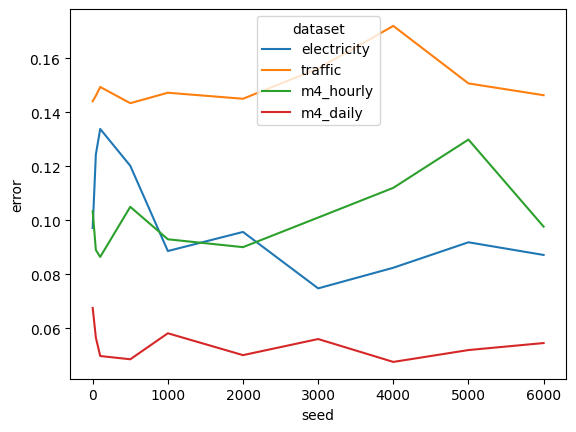

In [20]:
sns.lineplot(data=df, x="seed", y="error", hue="dataset")

In [23]:
value = []
for i, dim in zip(data,embedding_dim):
    # print(i, dim)
    dataset = get_dataset(i)
    prediction_length = 24
    freq = dataset.metadata.freq
    
    
    start_time = time.time()
    study = optuna.create_study(direction="minimize")
    study.optimize(TransformerTuningObjective(dataset, prediction_length = prediction_length, freq=freq, embed_dim=dim), n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    value.append(trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    print(time.time() - start_time)

[I 2023-01-25 14:11:52,365] A new study created in memory with name: no-name-7ba9abc2-a1a2-4360-9fe6-fa5d220bce23
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | TransformerModel | 249 K 
-------------------------------------------
249 K     Trainable params
0         Non-trainable params
249 K     Total params
0.996     Total estimated model params size (MB)


Epoch 0: : 0it [22:47:07, ?it/s]
Epoch 0: : 0it [00:00, ?it/s]

[W 2023-01-25 14:12:39,488] Trial 0 failed with parameters: {'context_length': 144, 'max_epochs': 7, 'batch_size': 256, 'num_encoder_layers': 2, 'num_decoder_layers': 10} because of the following error: KeyError(Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/torch/util.py", line 141, in __iter__
    yield from self.iterable
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 103, in __iter__
    yield from self.transformation(
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/torch/util.py", line 141, in __iter__
    yield from self.iterable
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 103, in __iter__
    yield from self.transformation(
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 124, in __call__
    for data_entry in data_it:
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 178, in __call__
    for data_entry in data_it:
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/itertools.py", line 71, in __iter__
    for el in self.iterable:
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 103, in __iter__
    yield from self.transformation(
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 128, in __call__
    raise e
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 126, in __call__
    yield self.map_transform(data_entry.copy(), is_train)
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/_base.py", line 141, in map_transform
    return self.transform(data)
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/convert.py", line 204, in transform
    r = [
  File "/Users/ariankhorasani/opt/anaconda3/lib/python3.8/site-packages/gluonts/transform/convert.py", line 207, in <listcomp>
    if data[fname] is not None
KeyError: 'time_feat'


In [66]:
df = pd.DataFrame({'dataset':data, 'error':value})
df['model'] = 'transformer'#vanilla
df.to_csv('df.csv', index=False)

In [ ]:
#To run hyperparameter tuning for each dataset

In [ ]:
# dataset = load_dataset("ett", "h2", prediction_length=24)
# freq = "1H"
# prediction_length = 24
# train_ds = ListDataset(dataset.train, freq=freq)
# # val_ds = ListDataset(dataset.validation, freq=freq)
# test_ds = ListDataset(dataset.test, freq=freq)
i = "solar-energy"# "electricity","traffic", "m4_hourly", "m4_daily", "m4_weekly", "m4_monthly", "m4_quarterly", "solar-energy"
dataset = get_dataset(i)
prediction_length = 24
freq = dataset.metadata.freq


In [ ]:
import time
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(TransformerTuningObjective(dataset, prediction_length = prediction_length, freq=freq, embed_dim=3), n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(time.time() - start_time)